# Replicating Bouttes' Asymmetry Experiment

We are aiming to find a linear relationship of
$ \lvert \int \mathcal{F}_{down}  dt \rvert \approx \alpha \lvert  \int \mathcal{F}_{up}  dt\rvert $

Bouttes had $\alpha = 0.58$ in their AOGCM simulations, depending on the simulation and scenario. We just want to replicate a linear relationship before and with the introduction of our temp. diff-dependent $\gamma (\Delta T)$. So with $\kappa = 0$ and $\kappa = ??$.

Bouttes looked at 2 types of positive forcing ($\mathcal{F}_{up}$): 4xCO2 const. and 1% increase. We will only do 4xCO2. I see no need to do both. 

To do this we need to:

1.  Implement forcing scenarios: 8xCO2 for 140 years, then -4xCO2 at t = 0, 25, 50, 75, 100, 150

    a.  with kappa = 0

    
    b.  with kappa = 0.1 (Picked because we don't (seem to) get the gamma cut off)

1.  Find time taken for temperature to go back to zero
1.  Use this time to find the integral of $\int_{T}\mathcal{F}_{down}dt$
1.  Plot $\int_{T}\mathcal{F}_{down}dt$ vs $\int_{T}\mathcal{F}_{up}dt$
1.  See whether it's linear and if so, what is the slope. 





## 1. Creating Forcing scenarios

We will use a shorter time range, of 500 years, as we will only do 140 years of 4xCO2 forcing. 


Implementing forcing scenarios, we should probably write to a file to save because we have been getting a lot of crashes... but how ugh

In [126]:
import json
import numpy as np
import matplotlib.pyplot as plt
from fair.constants import molwt
from fair.forcing.ghg import etminan, meinshausen
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.stats as sty
import random
import pandas as pd
from tqdm import tqdm
import random
import os

from ar6.utils import check_and_download, mkdir_p
from ar6.utils.statistics import weighted_percentile
from ar6.utils.h5 import *
from ar6.utils import mkdir_p
from ar6.constants.gases import ghg_to_rcmip_names
from ar6.forcing.aerosol import ghan, aerocom_n
from ar6.forcing.ozone import eesc
from ar6.constants.gases import rcmip_to_ghg_names, ghg_to_rcmip_names, ods_species, radeff
from multiprocessing import Pool

from ar6.twolayermodel import TwoLayerModel
from ar6.constants import NINETY_TO_ONESIGMA


In [127]:
ts = np.array([0,25,50,75,100,150])

f_scenarios = {}

for t in ts:
    force = (np.ones(500) * -4)
    force[:t] *= -2
    f_scenarios[t] = force


In [125]:
run_names = []

k = 0.1

for t in ts:
    run_names.append(f"t = %s, k = %s" %(t,0))
    run_names.append(f"t = %s, k = %s" %(t,k))



['t = 0, k = 0', 't = 0, k = 0.1', 't = 25, k = 0', 't = 25, k = 0.1', 't = 50, k = 0', 't = 50, k = 0.1', 't = 75, k = 0', 't = 75, k = 0.1', 't = 100, k = 0', 't = 100, k = 0.1', 't = 150, k = 0', 't = 150, k = 0.1']


In [128]:
runs = {}
kappas = [0, 0.1]

for k in kappas:    
    for t in ts:
        print(f"currently on kappa %s, t:%s " %(k,t))
        for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
            scm = TwoLayerModel(
                extforce= f_scenarios[t],
                exttime=np.arange(0,500),
                tbeg=0,
                tend=500,
                lamg=4.0/3.0,
                t2x=None,
                eff=1.29,
                cmix=6,
                cdeep=75,
                gamma_2l=0.7,
                kappa=k, 
                sigma = 0.01,
                outtime=np.arange(0,500),
                dt=1
            )
        
            out = scm.run()
    
        runs[f"t = %s, k = %s" %(t,k)] = out
    

currently on kappa 0, t:0 


100%|██████████| 1000/1000 [00:49<00:00, 20.40it/s]


currently on kappa 0, t:25 


100%|██████████| 1000/1000 [00:57<00:00, 17.46it/s]


currently on kappa 0, t:50 


100%|██████████| 1000/1000 [00:56<00:00, 17.77it/s]


currently on kappa 0, t:75 


100%|██████████| 1000/1000 [00:47<00:00, 21.04it/s]


currently on kappa 0, t:100 


100%|██████████| 1000/1000 [00:42<00:00, 23.66it/s]


currently on kappa 0, t:150 


100%|██████████| 1000/1000 [00:47<00:00, 20.93it/s]


currently on kappa 0.1, t:0 


100%|██████████| 1000/1000 [00:51<00:00, 19.38it/s]


currently on kappa 0.1, t:25 


100%|██████████| 1000/1000 [00:50<00:00, 19.76it/s]


currently on kappa 0.1, t:50 


100%|██████████| 1000/1000 [00:53<00:00, 18.55it/s]


currently on kappa 0.1, t:75 


100%|██████████| 1000/1000 [01:06<00:00, 15.12it/s]


currently on kappa 0.1, t:100 


100%|██████████| 1000/1000 [00:52<00:00, 19.19it/s]


currently on kappa 0.1, t:150 


100%|██████████| 1000/1000 [00:45<00:00, 21.82it/s]


In [154]:
#Finding time taken to get back to zero
#This could be improved.. Not doing proper methods to find return time

t_0k = []
t_01k = []
return_times = {}
for scen in runs:
    run = runs[scen] 
    #print(scen)
    t = int(scen[scen.find("= ")+2:scen.find(", ")])
    k = (scen[scen.find("k = ")+4:])
    #print(k)
    #print(t)
    minv= min(abs(run.tlev[:,1])[t:])
    i = np.where(abs(run.tlev[:,1]) == minv)
    return_times[scen] = run.time[i]
    if k == "0":
        t_0k.append(run.time[i][0])
    else:
        t_01k.append(run.time[i][0])

print(t_0k, t_01k)
print(return_times)


[0, 67, 123, 170, 213, 289] [0, 57, 104, 147, 187, 261]
{'t = 0, k = 0': array([0]), 't = 25, k = 0': array([67]), 't = 50, k = 0': array([123]), 't = 75, k = 0': array([170]), 't = 100, k = 0': array([213]), 't = 150, k = 0': array([289]), 't = 0, k = 0.1': array([0]), 't = 25, k = 0.1': array([57]), 't = 50, k = 0.1': array([104]), 't = 75, k = 0.1': array([147]), 't = 100, k = 0.1': array([187]), 't = 150, k = 0.1': array([261])}


0
1
2
3
4
5


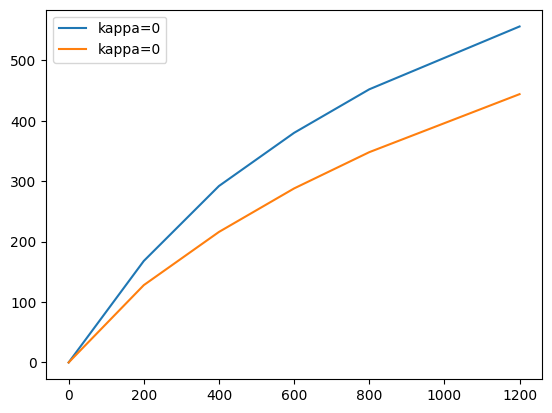

In [160]:
#Forcing Integrals

fint_up = []
fint_down0 = [] #when kappa = 0
fint_down01 = [] #when kappa = 0.1

for ind, t in enumerate(ts):
    print(ind)
    fint_up.append( 8 * t)
    fint_down0.append(4 * (t_0k[ind]-t))
    fint_down01.append(4 * (t_01k[ind]-t))

plt.plot(fint_up, fint_down0, label = "kappa=0")
plt.plot(fint_up, fint_down01, label = "kappa=0")
plt.legend()

[57]
[40]
[45]


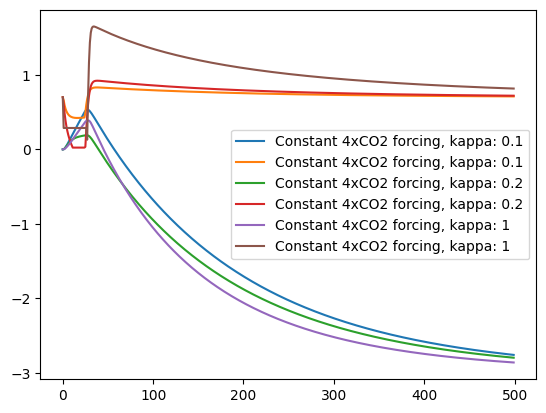

In [123]:
for name in runs:
    run = runs[name]    
    plt.plot(run.time, run.tlev[:,1] ,label =name  )
    plt.plot(run.time, run.gammas,label =name )
    minv= min(abs(run.tlev[:,1])[25:])

    #print(abs(run.tlev[:,1])[25:])
    #print(minv)
    i = np.where(abs(run.tlev[:,1]) == minv)
    print(run.time[i])
plt.legend()


In [161]:
runs_2 = {} #2nd round with epsilon = 1 to see if symmetric
kappas = [0]

for k in kappas:    
    for t in ts:
        print(f"currently on kappa %s, t:%s " %(k,t))
        for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
            scm = TwoLayerModel(
                extforce= f_scenarios[t],
                exttime=np.arange(0,500),
                tbeg=0,
                tend=500,
                lamg=4.0/3.0,
                t2x=None,
                eff=1,
                cmix=6,
                cdeep=75,
                gamma_2l=0.7,
                kappa=k, 
                sigma = 0.01,
                outtime=np.arange(0,500),
                dt=1
            )
        
            out = scm.run()
    
        runs_2[f"t = %s, k = %s" %(t,k)] = out

currently on kappa 0, t:0 


100%|██████████| 1000/1000 [01:07<00:00, 14.76it/s]


currently on kappa 0, t:25 


100%|██████████| 1000/1000 [01:00<00:00, 16.52it/s]


currently on kappa 0, t:50 


100%|██████████| 1000/1000 [00:45<00:00, 21.89it/s]


currently on kappa 0, t:75 


100%|██████████| 1000/1000 [00:54<00:00, 18.30it/s]


currently on kappa 0, t:100 


100%|██████████| 1000/1000 [00:44<00:00, 22.29it/s]


currently on kappa 0, t:150 


100%|██████████| 1000/1000 [00:42<00:00, 23.52it/s]


[0, 67, 123, 170, 213, 289] [0, 57, 104, 147, 187, 261]
0
1
2
3
4
5


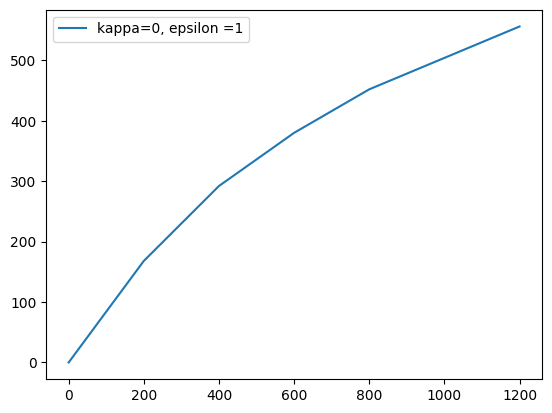

In [162]:
t_0k_0e = []


for scen in runs_2:
    run = runs_2[scen] 
    #print(scen)
    t = int(scen[scen.find("= ")+2:scen.find(", ")])
    k = (scen[scen.find("k = ")+4:])
    #print(k)
    #print(t)
    minv= min(abs(run.tlev[:,1])[t:])
    i = np.where(abs(run.tlev[:,1]) == minv)
    if k == "0":
        t_0k_0e.append(run.time[i][0])

print(t_0k, t_01k)

#Forcing Integrals

fint_up = []
fint_down0 = [] #when kappa = 0


for ind, t in enumerate(ts):
    print(ind)
    fint_up.append( 8 * t)
    fint_down0.append(4 * (t_0k[ind]-t))


plt.plot(fint_up, fint_down0, label = "kappa=0, epsilon =1")

plt.legend()




Why still not symmetric??? Should be.. I think we need to relook at what we are actually using for our forcings...